RNNレイヤの実装

In [1]:
class RNN:
  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.cache = None

  def forward(self, x, h_prev):
    Wx, Wh, b = self.params
    t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
    h_next = np.tanh(t)

    self.cache = (x, h_prev, h_next)
    return h_next

  def backward(self, dh_next):
    Wx, Wh, b = self.params
    x, h_prev, h_next = self.cache
    dt = dh_next * (1 - h_next ** 2)
    db = np.sum(dt, axis = 0)
    dWh = np.dot(h_prev.T, dt)
    dh_prev = np.dot(dt, Wh.T)
    dWx = np.dot(x.T, dt)
    dx = np.dot(dt, Wx.T)
    
    self.grads[0][...] = dWx
    self.grads[1][...] = dWh
    self.grads[2][...] = db
    return dx, dh_prev

Time　RNNレイヤの実装

In [2]:
class TimeRNN:
  def __init__(self, Wx, Wh, b, stateful=False):
    self.params = [Wx, Wh, b]
    self.params = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.layers = None

    self.h, self.dh = None, None
    self.stateful = stateful

  def set_state(self, h):
    self.h = h

  def reset_state(self):
    self.h = None

  def forward(self, xs):
    Wx, Wh, b = self.params
    N, T, D = xs.shape
    D, H = Wx.shape

    self.layers = []
    hs = np.empty((N, T, H), dtype='f')

    for t in range(T):
      layer = RNN(*self.params)
      self.h = layer.forward(xs[:, t, :], self.h)
      hs[:, t, :] = self.h
      self.layers.append(layer)
    return hs

  def backward(self, dhs):
    Wx, Wh, b = self.params
    N, T, H = dhs.shape
    D, H = Wx.shape

    dxs = np.empty((N, T, D), dtype='f')
    dh = 0
    grads = [0, 0, 0]
    for t in reversed(range(T)):
      layer = self.layers[t]
      dx, dh = layer.backward(dhs[:, t, :] + dh)
      dxs[:, t, :] = dx
      for i, grad in enumerate(layer.grads):
        grads[i] += grad
    for i, grad in enumerate(grads):
      self.grads[i][...] = grad
    self.dh = dh

    return dxs
      



In [8]:
from google.colab import drive
drive.mount('/content/drive')
dir_path = '/content/drive/My Drive/Colab Notebooks/'
import os
os.chdir(dir_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import numpy as np
from common.time_layers import *

SimpleRnnlmクラスの実装

In [13]:
class SimpleRnnlm:
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    embed_W = (rn(V, D)/100).astype('f')
    rnn_Wx = (rn(D, H)/np.sqrt(D)).astype('f')
    rnn_Wh = (rn(H, H)/np.sqrt(H)).astype('f')
    rnn_b = np.zeros(H).astype('f')
    affine_W = (rn(H, V)/np.sqrt(H)).astype('f')
    affine_b = np.zeros(V).astype('f')

    self.layers = [
        TimeEmbedding(embed_W),
        TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
        TimeAffine(affine_W, affine_b)
    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.rnn_layer = self.layers[1]

    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads

  def forward(self, xs, ts):
    for layer in self.layers:
      xs = layer.forward(xs)
    loss = self.loss_layer.forward(xs, ts)
    return loss

  def backward(self, dout = 1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout

  def reset_state(self):
    self.rnn_layer.reset_state()

RNNLMの学習

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb

In [18]:
#パラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5
lr = 0.1
max_epoch = 100
#学習ダータ読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus)+1)

xs = corpus[:-1]
ts = corpus[1:]
data_size = len(xs)
print('corpus size: %d, vocabulary size: %d,' % (corpus_size, vocab_size))
#学習時の変数
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []
#モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
#ミニバッチ初期化
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
  for iter in range(max_iters):
    batch_x = np.empty((batch_size, time_size), dtype="i")
    batch_t = np.empty((batch_size, time_size), dtype="i")
    for t in range(time_size):
      for i, offset in enumerate(offsets):
        batch_x[i, t] = xs[(offset + time_idx) % data_size]
        batch_t[i, t] = ts[(offset + time_idx) % data_size]
      time_idx += 1
    #勾配とパラメータの更新
    loss = model.forward(batch_x, batch_t)
    model.backward()
    optimizer.update(model.params, model.grads)
    total_loss += loss
    loss_count += 1

    #エポックごとの評価
  ppl = np.exp(total_loss / loss_count)
  print('| epoch %d | perplexity %.2f'
        % (epoch+1, ppl))
  ppl_list.append(float(ppl))
  total_loss, loss_count = 0, 0

corpus size: 1000, vocabulary size: 418,
| epoch 1 | perplexity 400.15
| epoch 2 | perplexity 278.80
| epoch 3 | perplexity 226.96
| epoch 4 | perplexity 217.23
| epoch 5 | perplexity 208.38
| epoch 6 | perplexity 202.92
| epoch 7 | perplexity 198.81
| epoch 8 | perplexity 197.36
| epoch 9 | perplexity 192.11
| epoch 10 | perplexity 192.24
| epoch 11 | perplexity 189.35
| epoch 12 | perplexity 192.38
| epoch 13 | perplexity 189.44
| epoch 14 | perplexity 189.92
| epoch 15 | perplexity 189.47
| epoch 16 | perplexity 186.01
| epoch 17 | perplexity 183.33
| epoch 18 | perplexity 179.51
| epoch 19 | perplexity 180.76
| epoch 20 | perplexity 181.18
| epoch 21 | perplexity 178.86
| epoch 22 | perplexity 174.49
| epoch 23 | perplexity 173.75
| epoch 24 | perplexity 172.94
| epoch 25 | perplexity 169.34
| epoch 26 | perplexity 168.76
| epoch 27 | perplexity 163.50
| epoch 28 | perplexity 160.59
| epoch 29 | perplexity 156.96
| epoch 30 | perplexity 151.43
| epoch 31 | perplexity 151.46
| epoch

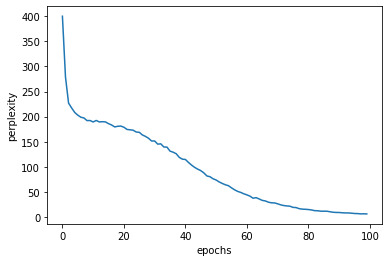

In [19]:
# グラフの描画
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

パープレキシティが確かに減少していることがグラフから確認できる。400ほどあった分岐数が、６程度まで減ったことでより予測の精度が高くなったといえる。

In [20]:
from common.trainer import RnnlmTrainer

model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)

| epoch 1 |  iter 1 / 19 | time 0[s] | perplexity 419.23
| epoch 2 |  iter 1 / 19 | time 0[s] | perplexity 396.74
| epoch 3 |  iter 1 / 19 | time 0[s] | perplexity 287.21
| epoch 4 |  iter 1 / 19 | time 0[s] | perplexity 224.94
| epoch 5 |  iter 1 / 19 | time 0[s] | perplexity 211.05
| epoch 6 |  iter 1 / 19 | time 0[s] | perplexity 209.90
| epoch 7 |  iter 1 / 19 | time 0[s] | perplexity 202.50
| epoch 8 |  iter 1 / 19 | time 0[s] | perplexity 201.03
| epoch 9 |  iter 1 / 19 | time 0[s] | perplexity 194.93
| epoch 10 |  iter 1 / 19 | time 0[s] | perplexity 190.23
| epoch 11 |  iter 1 / 19 | time 1[s] | perplexity 191.69
| epoch 12 |  iter 1 / 19 | time 1[s] | perplexity 187.87
| epoch 13 |  iter 1 / 19 | time 1[s] | perplexity 191.33
| epoch 14 |  iter 1 / 19 | time 1[s] | perplexity 185.68
| epoch 15 |  iter 1 / 19 | time 1[s] | perplexity 185.60
| epoch 16 |  iter 1 / 19 | time 1[s] | perplexity 188.77
| epoch 17 |  iter 1 / 19 | time 1[s] | perplexity 186.73
| epoch 18 |  iter 1 / 

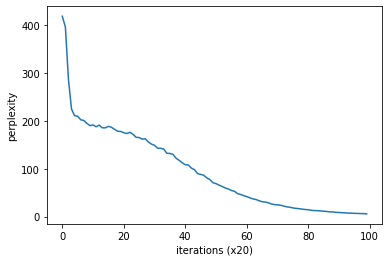

In [22]:
# グラフの描画
trainer.plot()

感想  
RNNの実装をした。理論部分がまだ完全に理解できていないため復習して身につけていきたい。

参考  
ゼロから作るDeepLearning2 5章「リカレントニューラルネットワーク（RNN）」